# General pipeline for project 1
This is an example pipeline showing you how to  
(1) Load the provided data;  
(2) Train models on the train set, and use the validation set to evaluate your model performance;  
(3) Generate predictions (pred.csv) on the test set, which is ready for submission.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [3]:
import torch
torch.cuda.is_available()

True

### (1) Loading data
The following code shows how to load the datasets for this project.  
Among which, we do not release the labels (the "stars" column) for the test set. You may evaluate your trained model on the validation set instead.

However, your submitted predictions (``pred.csv``) should be generated on the test set.

In [4]:
def load_data(split_name='train', columns=['text', 'stars'], folder='gdrive/MyDrive/COMP 4332/Project 1/data'):
  df = pd.read_csv(f'{folder}/{split_name}.csv')
  return df

In [5]:
train_df = load_data('train', columns=['text', 'stars'])
valid_df = load_data('valid', columns=['text', 'stars'])
test_df = load_data('test', columns=['text', 'stars'])

In [6]:
train_df['len'] = train_df['text'].apply(len)
valid_df['len'] = valid_df['text'].apply(len)
test_df['len'] = test_df['text'].apply(len)

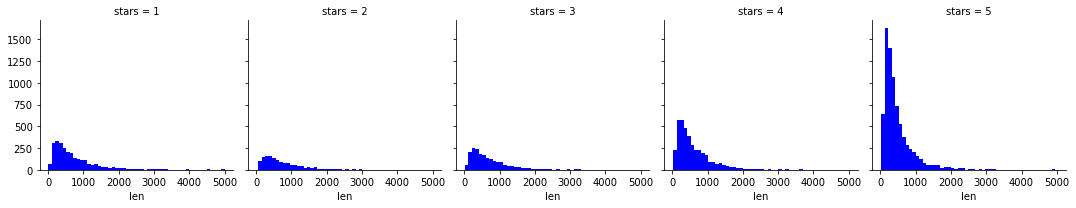

In [7]:
# Adding the length of each comments
import seaborn as sns
import matplotlib.pyplot as plt
graph = sns.FacetGrid(data=train_df,col='stars')
graph.map(plt.hist,'len',bins=50,color='blue')

In [8]:
train_stv = train_df.groupby('stars').mean()
print(train_stv.corr())
valid_str = valid_df.groupby('stars').mean()
print(valid_str.corr())

            cool     funny    useful       len
cool    1.000000 -0.145081 -0.688654 -0.487940
funny  -0.145081  1.000000  0.627414  0.917383
useful -0.688654  0.627414  1.000000  0.863814
len    -0.487940  0.917383  0.863814  1.000000
            cool     funny    useful       len
cool    1.000000 -0.255260 -0.554442 -0.365901
funny  -0.255260  1.000000  0.837943  0.802739
useful -0.554442  0.837943  1.000000  0.729079
len    -0.365901  0.802739  0.729079  1.000000


Positive pair : (funny,useful),(funny,len),(useful,len)

Negative pair : (cool,*)

In [9]:
# test_df.columns
print(train_df.columns)
print(valid_df.columns)
print(test_df.columns)
#test_df

Index(['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text',
       'useful', 'user_id', 'len'],
      dtype='object')
Index(['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text',
       'useful', 'user_id', 'len'],
      dtype='object')
Index(['business_id', 'cool', 'date', 'funny', 'review_id', 'text', 'useful',
       'user_id', 'len'],
      dtype='object')


### (2) Training and validating 
The following example shows you how to train your model using the train set, and evaluate on the validation set.  
As an example, we only use the text data for training. Feel free to use other columns in your implementation.  

The model performance on the validation set can be roughly regarded as your models final performance, so we can use it to search for optimal hyper-parameters.

 You can use the valid data to choose the hyperparameters.
As an example, you can decide which value of C (1 or 100) is better by evaluating on the valid data.

In [10]:
import nltk
nltk.download("stopwords")
nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
ps = PorterStemmer()

def lower(s):
    """
    :param s: a string.
    return a string with lower characters
    Note that we allow the input to be nested string of a list.
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: 'text mining is to identify useful information.'
    """
    if isinstance(s, list):
        return [lower(t) for t in s]
    if isinstance(s, str):
        return s.lower()
    else:
        raise NotImplementedError("unknown datatype")


def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)


def n_gram(tokens, n=1):
    """
    :param tokens: a list of tokens, type: list
    :param n: the corresponding n-gram, type: int
    return a list of n-gram tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.'], 2
    Output: ['text mine', 'mine is', 'is to', 'to identifi', 'identifi use', 'use inform', 'inform .']
    """
    if n == 1:
        return tokens
    else:
        results = list()
        for i in range(len(tokens)-n+1):
            # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
            results.append(" ".join(tokens[i:i+n]))
        return results

def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     if token not in stopwords and not token.isnumeric():
    #         results.append(token)
    # return results

    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

import numpy as np

def get_onehot_vector(feats, feats_dict):
    """
    :param data: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=np.float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
"""
train_df['text'] = train_df['text'].map(tokenize).map(filter_stopwords).map(lower)
valid_df['text'] = valid_df['text'].map(tokenize).map(filter_stopwords).map(lower)
test_df['text'] = test_df['text'].map(tokenize).map(filter_stopwords).map(lower)
"""

"\ntrain_df['text'] = train_df['text'].map(tokenize).map(filter_stopwords).map(lower)\nvalid_df['text'] = valid_df['text'].map(tokenize).map(filter_stopwords).map(lower)\ntest_df['text'] = test_df['text'].map(tokenize).map(filter_stopwords).map(lower)\n"

In [12]:
#Using text data only

x_train = train_df['text']
y_train = train_df['stars']
  
x_valid = valid_df['text']
y_valid = valid_df['stars']

x_test = test_df['text']

In [13]:
x_train
x_valid
x_test

0       OMG! I'm an avid spray tanner and have been al...
1       Sets the standard. Authentic. Outstanding. Cou...
2       Came on 7/23/2014 with a group of 10 - service...
3       I love Bobs Subs! Tasty n made to order...yum!...
4       This is my hotel of choice on the strip.  I re...
                              ...                        
3995    I have a glass wall and ceiling sunroom by Fou...
3996    I love Kohls. My favorite place to clothes sho...
3997    Wow, this was genuinely terrible food. I order...
3998    Worst service ever! My clothes were tagged wro...
3999    Love/love/love Tina for pink/white.  I recentl...
Name: text, Length: 4000, dtype: object

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransfor
vocab = TfidfVectorizer(tokenizer=tokenize)#analyzer=lambda x: x
x_train = vocab.fit_transform(x_train)
X_valid = vocab.fit_transform(x_valid)
x_test = vocab.fit_transform(x_test)

# Naive Bayes

In [15]:
tfidf = TfidfVectorizer(tokenizer=tokenize)#analyzer=lambda x: x
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
steps = [('tfidf', tfidf),('mnb', mnb)]
pipe = Pipeline(steps)
print(pipe)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7f89a1203710>)),
                ('mnb', MultinomialNB())])


In [21]:
x_train.todense()

matrix([[0.0602713 , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.08221672, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.02572066, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [16]:
pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_valid)
print(classification_report(y_valid, y_pred))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

AttributeError: ignored

# Decision Tree

In [17]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
steps = [('tfidf', tfidf),('dt', dt)]
pipe = Pipeline(steps)
print(pipe)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7f89a1203710>)),
                ('dt', DecisionTreeClassifier())])


In [19]:
pipe.fit(list(x_train), list(y_train))
y_pred = pipe.predict(list(x_valid))
print(classification_report(list(y_valid), y_pred))
print("\n\n")
print(confusion_matrix(list(y_valid), y_pred))
print('accuracy', np.mean(list(y_valid) == y_pred))

AttributeError: ignored

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
steps = [('tfidf', tfidf),('dt', dt)]
pipe = Pipeline(steps)
print(pipe)

In [ ]:
pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_valid)
print(classification_report(y_valid, y_pred))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

# Gradient Boost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbe = GradientBoostingClassifier(random_state=0)
parameters = {
     'learning_rate': [0.05, 0.1, 0.5],
    'max_features': [0.25,0.5, 1],
    'max_depth': [2,3, 4, 5]}
gridsearch=GridSearchCV(gbe,parameters,cv=100,scoring='roc_auc')
gridsearch.fit(x_train,y_train)
print(gridsearch.best_params_)
print(gridsearch.best_score_)

# CatBoost

In [ ]:
# build the second linear model with TFIDF feature
tfidf = TfidfVectorizer()
lr2 = LogisticRegression(C=1)
steps = [('tfidf', tfidf),('lr', lr2)]
pipe2 = Pipeline(steps)

In [ ]:
# train the second model
pipe2.fit(x_train, y_train)

In [ ]:
# validate on the validation set
y_pred = pipe2.predict(x_valid)
print(classification_report(y_valid, y_pred))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

 We find the second model (pipe2) has higher accuracy, then we use the second model to make predictions on test data. In practice, you may not only focus on the accuracy, but also other metrics (precision, recall, f1), since the label distribution is not always balanced.

### (3) Generate predictions on the test set

In [ ]:
predict_test = pipe2.predict(x_test)

In [ ]:
predict_test

In [ ]:
# save your model predictions
pred_df = pd.DataFrame({'stars': predict_test, 'review_id': test_df['review_id']})
pred_df.to_csv('pred.csv', index=False)

 Then you may submit the predictions `pred.csv` on the test set. 